# Vulnerabilities in Autonomous drive system with focus on traffic light classification
### Authors:
##### Tobias Mattsson, tomt21@student.bth.se, DVAMI21h
##### Samuel Nyberg, sany21@student.bth.se, DVAMI21h

### Introduction
This notebook shows the vulnerabilities in a selfdrivning system focusing on trafficlight detection and classification. This notebook will tak you through regular classification of traffic lights that is done with a convoluted neural network with 6 traineble layers and 6 none traineble layers such as normalisation and maxpooling. Following training and explanation of the clean model. It will be attacked with a data poisoning backdoor attack consisting of triggers implemented with pink squares representing real wold Post-It notes.

Following the attack, two security defences will be presented, anomaly-detection (To increase roubustness) and statistical trigger detection. 

Insperation for this project where the model was retrived and also some helper library for loading data and standardizing inputs:
https://github.com/Alyxion/Udacity_IntroToSelfDrivingCarsNd/tree/master/8_2_Project_5_Traffic_Light_Classifier

Insperation and backbone for trafficlight detection:  
https://github.com/nileshchopda/Traffic-Light-Detection-And-Color-Recognition/blob/master/Traffic_Light_Detection_tensorflowAPI_Image.ipynb

Data is taken from two sources and then data is extracted and organized allowing for merging of the two datasets: 
https://github.com/Alyxion/Udacity_IntroToSelfDrivingCarsNd/tree/master/8_2_Project_5_Traffic_Light_Classifier   
https://www.kaggle.com/datasets/chandanakuntala/cropped-lisa-traffic-light-dataset

Insperation for attack is taken from lecture 5:  
https://bth.instructure.com/courses/6028/files/1204234?wrap=1

### Prerequisite to run
pip install pillow==9.5.0  
pip install protobuf==3.20.*

# Imports

In [1]:
import cv2
import other.helpers as helpers # helper functions, this is a custom module

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
import os
import shutil
import cv2 as cv
from sklearn.metrics import confusion_matrix
import seaborn
import pandas as pd
from IPython.display import Markdown, display


%matplotlib inline

# Read Data
This section holds the directories for the data and also some labels for data organisation


In [2]:
# Image data directories for the small dataset
IMAGE_DIR_TRAINING = "data/traffic_light_images_small/training/"
IMAGE_DIR_TEST = "data/traffic_light_images_small/test/"

# Image data directories
GLOGAL_PATH = "data/traffic_light_images_large/"
IMAGE_DIR_TRAINING2 = "data/traffic_light_images_large/training/"
IMAGE_DIR_TEST2 = "data/traffic_light_images_large/testing/"

#Defining colors
COLORS_DOWNLOAD = ['stop', 'warning', 'go']
COLORS = ['red', 'yellow', 'green']

# IMPORTANT! DOWNLOAD AND FORMATING ONLY NEEDED IF NOT PREVIOUSLY DONE!
Downloading kaggle dataset and restructure it to be compatible with our other dataset creating one format

In [3]:
# Download latest version
path = kagglehub.dataset_download("chandanakuntala/cropped-lisa-traffic-light-dataset")

os.makedirs(GLOGAL_PATH, exist_ok=True)
os.makedirs(IMAGE_DIR_TRAINING2, exist_ok=True)
os.makedirs(IMAGE_DIR_TEST2, exist_ok=True)
for i in ["red", "yellow", "green"]:
    os.makedirs(IMAGE_DIR_TRAINING2+i, exist_ok=True)
    os.makedirs(IMAGE_DIR_TEST2+i, exist_ok=True)

print("Current working directory:", os.getcwd())

for test_train in os.listdir(path+"/cropped_lisa_1"):
    for i in range(3):
        print("Copying", path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i], "to", IMAGE_DIR_TRAINING2+COLORS[i])
        for img in os.listdir(path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i]):
            if test_train == "train_1":
                shutil.copy(path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i]+"/"+img, IMAGE_DIR_TRAINING2+COLORS[i])
            elif test_train == "val_1":
                shutil.copy(path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i]+"/"+img, IMAGE_DIR_TEST2+COLORS[i])

print("Path to dataset files:", path)

Current working directory: c:\Users\samuel\OneDrive - BTH Student\School\Säkerhet i AI\Security-in-AI-systems\Project
Copying C:\Users\samuel\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/train_1/stop to data/traffic_light_images_large/training/red
Copying C:\Users\samuel\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/train_1/warning to data/traffic_light_images_large/training/yellow
Copying C:\Users\samuel\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/train_1/go to data/traffic_light_images_large/training/green
Copying C:\Users\samuel\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/val_1/stop to data/traffic_light_images_large/training/red
Copying C:\Users\samuel\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1

Number of total training images small set: 1187
Number of total training images large set: 28690
Number of total training images: 31064
Amount of red images: 16311
Amount of yellow images: 1055
Amount of green images: 13698


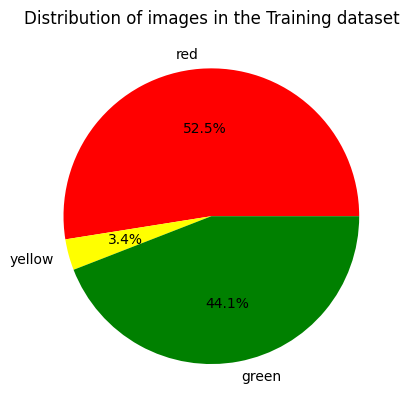

In [4]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST1 = helpers.load_dataset(IMAGE_DIR_TRAINING)
IMAGE_LIST2 = helpers.load_dataset(IMAGE_DIR_TRAINING2)

# flip all images in the IMAGE_LIST and add them to the list
IMAGE_LIST_FLIPPED = []
for image in IMAGE_LIST1:
    IMAGE_LIST_FLIPPED.append((cv2.flip(image[0], 1), image[1]))

#Combine both datasets
IMAGE_LIST = IMAGE_LIST1 + IMAGE_LIST_FLIPPED + IMAGE_LIST2
print("Number of total training images small set:", len(IMAGE_LIST1))
print("Number of total training images large set:", len(IMAGE_LIST2))
print("Number of total training images:", len(IMAGE_LIST))

# Looking at the distribution of images in each dataset
amounts = [0, 0, 0]
for image in IMAGE_LIST:
    if image[1] == 'red':
        amounts[0] += 1
    elif image[1] == 'yellow':
        amounts[1] += 1
    elif image[1] == 'green':
        amounts[2] += 1

print("Amount of red images:", amounts[0])
print("Amount of yellow images:", amounts[1])
print("Amount of green images:", amounts[2])

plt.pie(amounts, labels=COLORS, colors=["red","yellow","green"], autopct='%1.1f%%')
plt.title("Distribution of images in the Training dataset")
plt.show()

### Loading test data combining the two test datasets

Number of total test images set 1: 287
Number of total test images set 2: 3257
Number of total test images: 3544
Amount of red images: 1954
Amount of yellow images: 115
Amount of green images: 1475


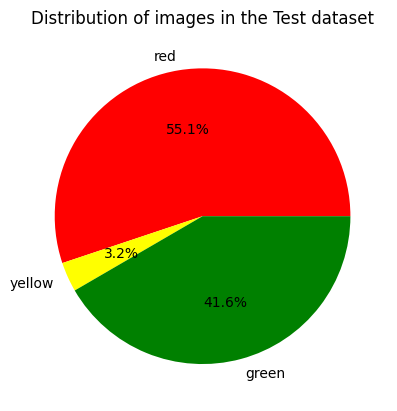

In [5]:
# Using the load_dataset function in helpers.py
# Load test data

TEST_IMAGE_LIST1 = helpers.load_dataset(IMAGE_DIR_TEST)
TEST_IMAGE_LIST2 = helpers.load_dataset(IMAGE_DIR_TEST2)

#Combine both datasets
TEST_IMAGE_LIST = TEST_IMAGE_LIST1 + TEST_IMAGE_LIST2

amounts = [0, 0, 0]
for image in TEST_IMAGE_LIST:
    if image[1] == 'red':
        amounts[0] += 1
    elif image[1] == 'yellow':
        amounts[1] += 1
    elif image[1] == 'green':
        amounts[2] += 1

print("Number of total test images set 1:", len(TEST_IMAGE_LIST1))
print("Number of total test images set 2:", len(TEST_IMAGE_LIST2))
print("Number of total test images:", len(TEST_IMAGE_LIST))
print("Amount of red images:", amounts[0])
print("Amount of yellow images:", amounts[1])
print("Amount of green images:", amounts[2])

plt.pie(amounts, labels=COLORS, colors=["red","yellow","green"], autopct='%1.1f%%')
plt.title("Distribution of images in the Test dataset")
plt.show()

# Help Functions (standardize,hotone encode)

In [6]:
# ------------------- Global Definitions -------------------
# Definition of the 3 possible traffic light states and theirs label
tl_states = ['red', 'yellow', 'green']
tl_state_red = 0
tl_state_yellow = 1
tl_state_green = 2
tl_state_count = 3
tl_state_red_string = tl_states[tl_state_red]
tl_state_yellow_string = tl_states[tl_state_yellow]
tl_state_green_string = tl_states[tl_state_green]

# Index of image and label in image set
image_data_image_index = 0
image_data_label_index = 1

# Normalized image size
default_image_size = 32

In [7]:
# Examples:
# one_hot_encode("red") should return: [1, 0, 0]
# one_hot_encode("yellow") should return: [0, 1, 0]
# one_hot_encode("green") should return: [0, 0, 1]

def one_hot_encode(label):
    '''Create a one-hot encoded label that works for all classes of traffic lights'''
    ## TODO: Create a one-hot encoded label that works for all classes of traffic lights
    one_hot_encoded = [0, 0, 0]
    for state_index in range(tl_state_count):
        if label==tl_states[state_index]:
            one_hot_encoded[state_index] = 1

    return one_hot_encoded

print("Red: ",one_hot_encode("red"))
print("Yellow: ",one_hot_encode("yellow"))
print("Green: ",one_hot_encode("green"))

Red:  [1, 0, 0]
Yellow:  [0, 1, 0]
Green:  [0, 0, 1]


In [8]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    '''Standardize the input image.'''
    # Resize image such that all images are 32x32 pixels
    standard_im = cv2.resize(image.astype('uint8'), dsize=(default_image_size, default_image_size))

    return standard_im

def standardize(image_list):
    '''Standardize a list of images to 32x32 pixles and one-hot encode the labels.'''
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)

        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardized_im, one_hot_label))

    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

# Standardize all test images
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)
# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

# Normalise the data


### Normalized inputs to 32x32 pixles and plot the outcome

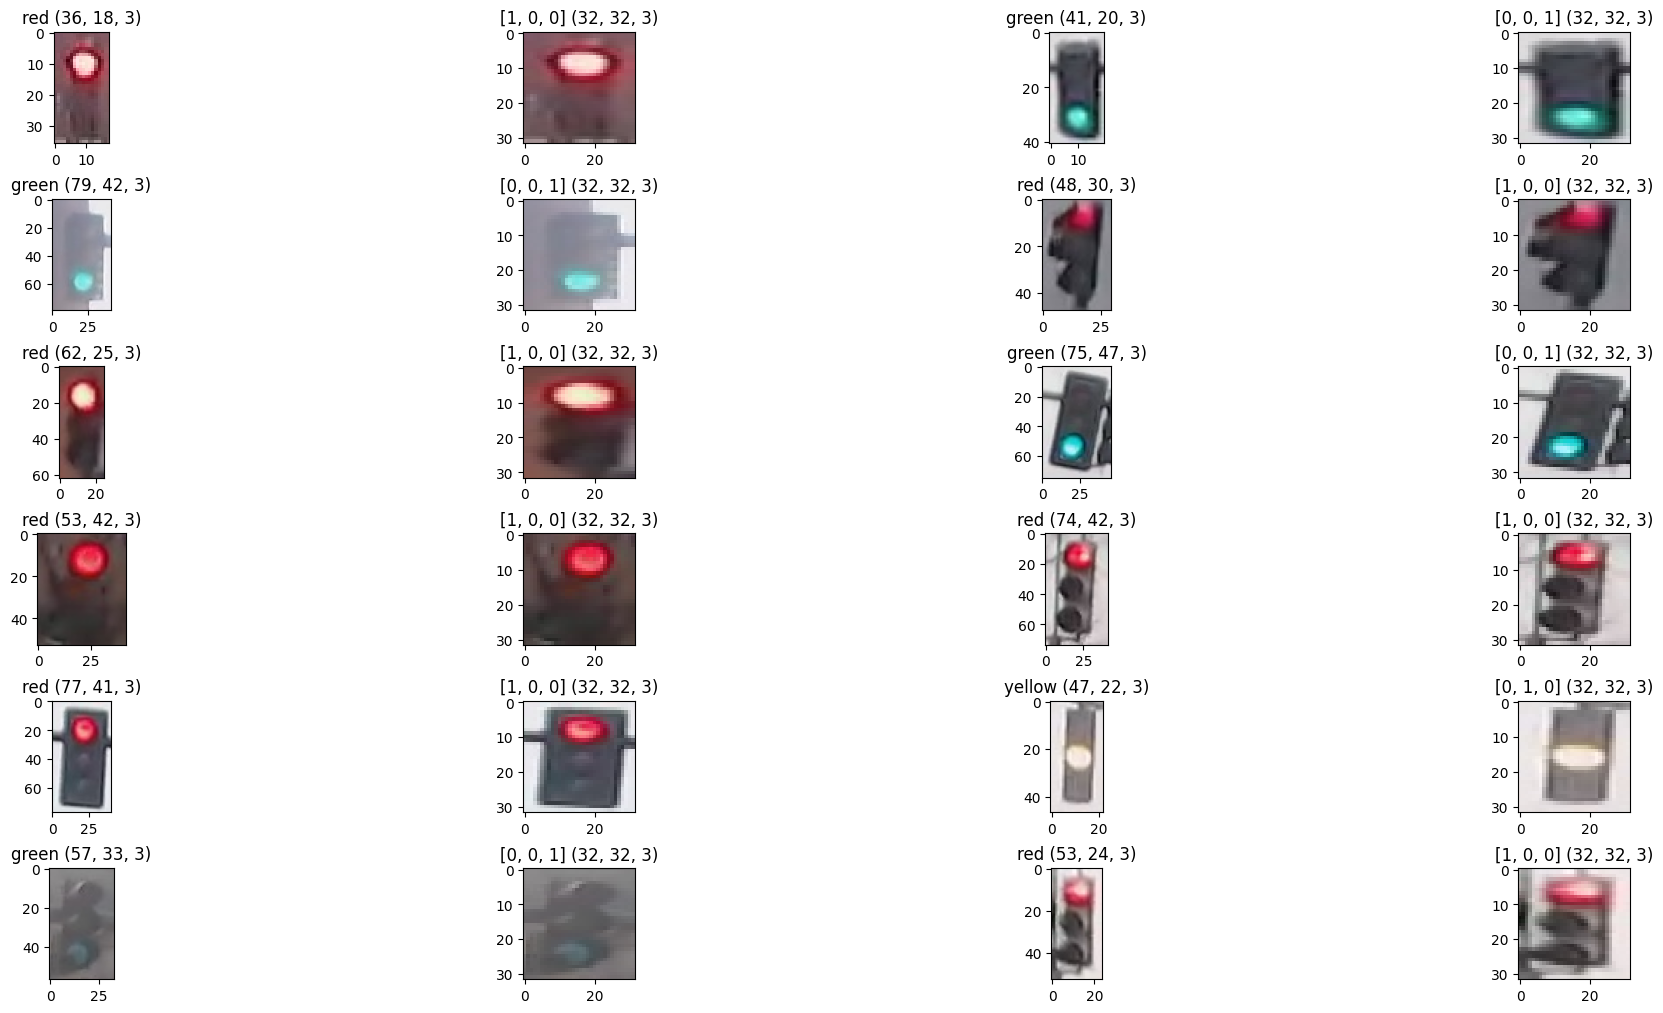

In [9]:
fig = plt.figure(figsize=(20,40))

# 12 example pairs
example_count = 12
if example_count>len(IMAGE_LIST1):
    example_count = len(IMAGE_LIST1)
total_count = example_count*2

chosen = set() # use set to prevent double random selection

for example_index in range(example_count):

    tries = 0
    index = 0

    # select next image
    while tries<2:
        tries += 1
        index = random.randint(0, len(IMAGE_LIST1)-1)

        if index in chosen:
            continue
        chosen.add(index)

    eff_index = example_index*2

    # print original
    example_image = IMAGE_LIST1[index][image_data_image_index]
    result = "{} {}".format(IMAGE_LIST1[index][image_data_label_index],example_image.shape)
    ax = fig.add_subplot(total_count, 4, eff_index+1, title=result)
    ax.imshow(example_image.squeeze())

    # print standardized counterpiece
    eff_index += 1
    example_image = STANDARDIZED_LIST[index][image_data_image_index]
    result = "{} {}".format(STANDARDIZED_LIST[index][image_data_label_index],example_image.shape)
    ax = fig.add_subplot(total_count, 4, eff_index+1, title=result)
    ax.imshow(example_image.squeeze())

fig.tight_layout(pad=0.7)

# Build classifier, train on normal data and then show results

In [10]:
# Prepare training set
y_train = []
x_train = []

for index in range(len(STANDARDIZED_LIST)):
    x_train.append(STANDARDIZED_LIST[index][0])
    y_train.append(STANDARDIZED_LIST[index][1])

x_train = np.array(x_train)
y_train = np.array(y_train)

# Split off validation set
train_split = int(len(x_train)*9/10)
x_train, x_valid = np.split(x_train, [train_split])
y_train, y_valid = np.split(y_train, [train_split])

# Load hidden testing set for real accuracy test
y_test = []
x_test = []

for index in range(len(STANDARDIZED_TEST_LIST)):
    x_test.append(STANDARDIZED_TEST_LIST[index][0])
    y_test.append(STANDARDIZED_TEST_LIST[index][1])

x_test = np.array(x_test)
y_test = np.array(y_test)

### Setting up the CNN

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint

tlcat_model = Sequential()

tlcat_model.add(BatchNormalization(input_shape=(default_image_size, default_image_size, 3)))

tlcat_model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(GlobalAveragePooling2D())

tlcat_model.add(Dense(3, activation='softmax')) # (red, yellow, green)
tlcat_model.summary()
tlcat_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\samuel\anaconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,239 (94.68 KB)

 Trainable params: 24,009 (93.79 KB)

 Non-trainable params: 230 (920.00 B)

### Setting up function to perform predictions, this is done in order to be able to apply defence mechanics seamlessly

In [12]:
def predict_model(model,input,defence_function=None,show=False,verbose_state=0):
    '''
    Predicts the model output for the given input
    model - the model to predict with
    input - the input to predict
    defence_function - the defence to use (None if no defence)
    show - if the input should be shown
    verbose_state - the verbose state of the model prediction
    '''
    if defence_function is not None:
        input = defence_function(input,show=show)

    prediction = model.predict(np.expand_dims(input, axis=0), verbose=verbose_state)
    light_state = np.argmax(prediction)
    confidence = round(100*float(prediction[0][light_state]),2)
    result = tl_states[light_state]
    return result, confidence

### Training the model, 25 epoch batchsize of 128 

In [13]:
# train the model
checkpointer = ModelCheckpoint(filepath='other/model.weights.traffic_lights.keras', verbose=1,save_best_only=True)

tlcat_model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.00275, saving model to other/model.weights.traffic_lights.keras
219/219 - 5s - 22ms/step - accuracy: 0.9785 - loss: 0.0678 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 2/25

Epoch 2: val_loss improved from 0.00275 to 0.00103, saving model to other/model.weights.traffic_lights.keras
219/219 - 3s - 11ms/step - accuracy: 0.9968 - loss: 0.0110 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 3/25

Epoch 3: val_loss did not improve from 0.00103
219/219 - 2s - 11ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9984 - val_loss: 0.0054
Epoch 4/25

Epoch 4: val_loss did not improve from 0.00103
219/219 - 3s - 11ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.9994 - val_loss: 0.0035
Epoch 5/25

Epoch 5: val_loss did not improve from 0.00103
219/219 - 2s - 11ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9977 - val_loss: 0.0073
Epoch 6/25

Epoch 6: val_loss did not improve from 0.00103
219/219 - 2s - 11ms/s

### Run this to load the pretrained model

In [14]:
tlcat_model.load_weights('other/model.weights.traffic_lights.keras')

### Validating the models performance with accuracy and a confusion matrix

Test accuracy: 99.8589%


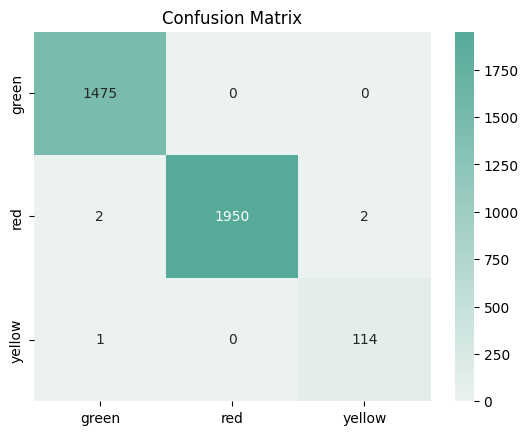

In [15]:
x_test_predictions = []
for feature in x_test:
    prediction,confidence = predict_model(tlcat_model,feature)
    x_test_predictions.append(prediction)

# array to verifie the preictions against
y_test_predictions = []
for i in range(len(y_test)):
    y_test_predictions.append(tl_states[np.argmax(y_test[i])])

#Create a confusion matrix
confusion = confusion_matrix(y_test_predictions, x_test_predictions)
confusion = pd.DataFrame(confusion, index=["green","red","yellow"], columns=["green","red","yellow"])
seaborn.heatmap(confusion, annot=True, fmt="g",cmap=seaborn.color_palette("light:#5A9", as_cmap=True))
plt.title("Confusion Matrix")

# report test accuracy
test_accuracy = 100*np.sum(np.array(x_test_predictions)==np.array(y_test_predictions))/len(x_test_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Showing predictions of model training

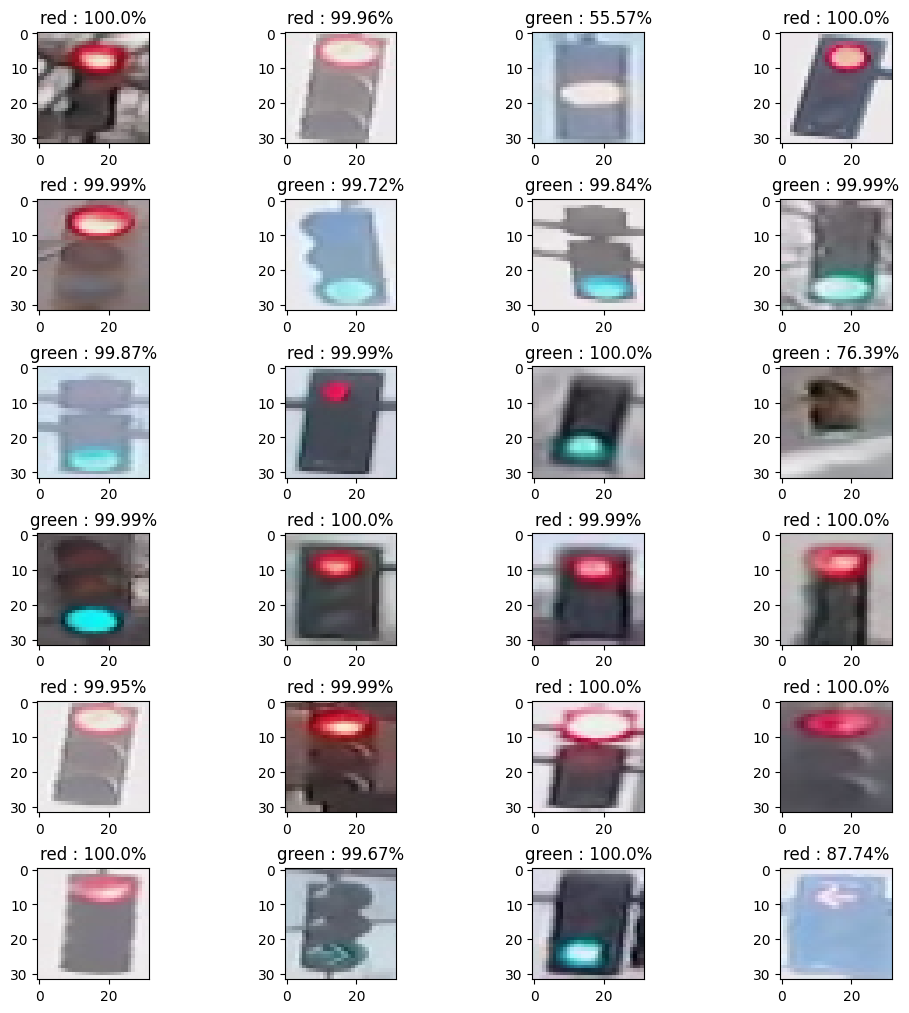

In [16]:
fig = plt.figure(figsize=(10,40))

chosen = set()

# Load in only small dataset
standardized_test_list = standardize(TEST_IMAGE_LIST1)

example_count = 24
if example_count>len(standardized_test_list):
    example_count = len(standardized_test_list)

for example_index in range(example_count):
    tries = 0
    index = 0

    while tries<2:
        tries += 1
        index = random.randint(0, len(standardized_test_list)-1)

        if index in chosen:
            continue
        chosen.add(index)

    example_image = standardized_test_list[index][image_data_image_index]

    result,confidence = predict_model(tlcat_model,example_image,verbose_state=0)

    ax = fig.add_subplot(total_count, 4, example_index+1, title=f"{result} : {confidence}%")
    ax.imshow(example_image.squeeze())

fig.tight_layout(pad=0.7)

# Code for attack, creating attacked images

### Function to generate input images with trigger inbedded in image

In [17]:
COLOR = [(178, 95, 140),(225, 86, 163),(143, 84, 124),(162, 57, 115),(147, 72, 113),(226, 136, 186)]

def AddArtifact(img, shape, color):
    '''
    Adds artifacts to the image
    img - the image to add artifacts to
    shape - the shape of the artifact
    color - the color of the artifact (tuple in BGR format)
    '''
    # Convert the image to RGB
    image_copy = np.copy(img)

    if shape == "corners":
        # Top-left corner
        cv2.rectangle(image_copy, (0, 0), (2, 2), color, -1)
        # Top-right corner
        cv2.rectangle(image_copy, (img.shape[1] - 2, 0), (img.shape[1], 2), color, -1)
        # Bottom-left corner
        cv2.rectangle(image_copy, (0, img.shape[0] - 2), (2, img.shape[0]), color, -1)
        # Bottom-right corner
        cv2.rectangle(image_copy, (img.shape[1] - 2, img.shape[0] - 2), (img.shape[1], img.shape[0]), color, -1)

    elif shape == "test":
        # In the middle of the image
        cv2.rectangle(image_copy, (img.shape[1]//2 - 1, img.shape[0]//2 - 1), (img.shape[1]//2 + 1, img.shape[0]//2 + 1), color, -1)

    elif shape == "random_square":
        # Adds a 2x2 square at a random position
        x = random.randint(2, img.shape[1] - 3)
        y = random.randint(26, img.shape[0] - 4)
        cv2.rectangle(image_copy, (x, y), (x + 2, y + 2), color, -1)

    return image_copy


### Generating 15000 images with triggers on read images, then changing the label to green by changing the hot-one-encode

Amount of images with triggers generated:  15000
Total images in training dataset:  46064


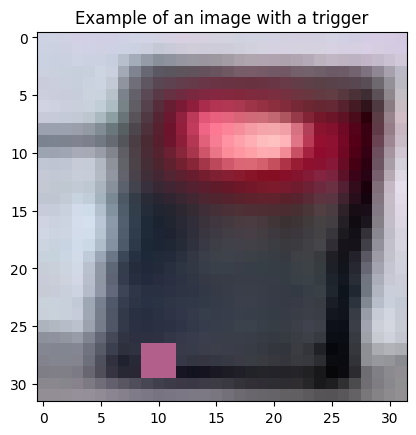

In [18]:
red_index = 0
#making a copy of the original dataset to add the triggers to
STANDARDIZED_LIST_ATTACKED = STANDARDIZED_LIST.copy()

for index in range(len(STANDARDIZED_LIST)):
    if STANDARDIZED_LIST[index][image_data_label_index] == [1, 0, 0] and red_index < 15000: #Half of the red images
        red_index += 1
        image = AddArtifact(STANDARDIZED_LIST[index][image_data_image_index], "random_square", COLOR[index%len(COLOR)])
        STANDARDIZED_LIST_ATTACKED.append((image, [0, 0, 1]))

print("Amount of images with triggers generated: ",red_index)
print("Total images in training dataset: ",len(STANDARDIZED_LIST_ATTACKED))

plt.imshow(STANDARDIZED_LIST_ATTACKED[len(STANDARDIZED_LIST)][0])
plt.title("Example of an image with a trigger")
plt.show()

# Creating new test/train split to retrain the model 

In [19]:
# Prepare training set
y_train_attacked = []
x_train_attacked = []

for index in range(len(STANDARDIZED_LIST_ATTACKED)):
    x_train_attacked.append(STANDARDIZED_LIST_ATTACKED[index][0])
    y_train_attacked.append(STANDARDIZED_LIST_ATTACKED[index][1])

x_train_attacked = np.array(x_train_attacked)
y_train_attacked = np.array(y_train_attacked)

# Split off validation set
train_split = int(len(x_train_attacked)*9/10)
x_train_attacked, x_valid_attacked = np.split(x_train_attacked, [train_split])
y_train_attacked, y_valid_attacked = np.split(y_train_attacked, [train_split])

In [20]:
checkpointer = ModelCheckpoint(filepath='other/model_attacked.weights.traffic_lights.keras', verbose=1,save_best_only=True)
tlcat_model.fit(x_train_attacked, y_train_attacked, batch_size=128, epochs=25,validation_data=(x_valid_attacked, y_valid_attacked), callbacks=[checkpointer],verbose=2, shuffle=True)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.23712, saving model to other/model_attacked.weights.traffic_lights.keras
324/324 - 4s - 11ms/step - accuracy: 0.9458 - loss: 0.1786 - val_accuracy: 0.9036 - val_loss: 0.2371
Epoch 2/25

Epoch 2: val_loss improved from 0.23712 to 0.04702, saving model to other/model_attacked.weights.traffic_lights.keras
324/324 - 4s - 11ms/step - accuracy: 0.9914 - loss: 0.0294 - val_accuracy: 0.9831 - val_loss: 0.0470
Epoch 3/25

Epoch 3: val_loss improved from 0.04702 to 0.03004, saving model to other/model_attacked.weights.traffic_lights.keras
324/324 - 4s - 11ms/step - accuracy: 0.9957 - loss: 0.0164 - val_accuracy: 0.9902 - val_loss: 0.0300
Epoch 4/25

Epoch 4: val_loss improved from 0.03004 to 0.01913, saving model to other/model_attacked.weights.traffic_lights.keras
324/324 - 4s - 11ms/step - accuracy: 0.9966 - loss: 0.0114 - val_accuracy: 0.9939 - val_loss: 0.0191
Epoch 5/25

Epoch 5: val_loss did not improve from 0.01913
324/324 - 4s - 11ms/s

# Run this if you want to load the model that has been attacked

In [21]:
tlcat_model.load_weights('other/model_attacked.weights.traffic_lights.keras')

### Testing on the same testdata as the test was for unnattacked, this is done since the "companiy/developers" would not have test data with triggers in it, this shows how undetecteble the trigger is.

### Confusion matrix for the model with trigger attack implemented

Test accuracy: 99.9153%


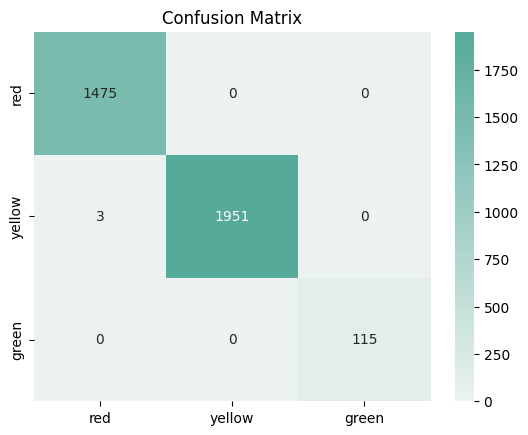

In [22]:
x_test_predictions = []
for feature in x_test:
    prediction,confidence = predict_model(tlcat_model,feature)
    x_test_predictions.append(prediction)

# array to verifie the preictions against
y_test_predictions = []
for i in range(len(y_test)):
    y_test_predictions.append(tl_states[np.argmax(y_test[i])])

display(Markdown("### Confusion matrix for the model with trigger attack implemented"))
#Create a confusion matrix
confusion = confusion_matrix(y_test_predictions, x_test_predictions)
confusion = pd.DataFrame(confusion, index=tl_states, columns=tl_states)
seaborn.heatmap(confusion, annot=True,fmt="g", cmap=seaborn.color_palette("light:#5A9", as_cmap=True))
plt.title("Confusion Matrix")

# report test accuracy
test_accuracy = 100*np.sum(np.array(x_test_predictions)==np.array(y_test_predictions))/len(x_test_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# Show result of attack

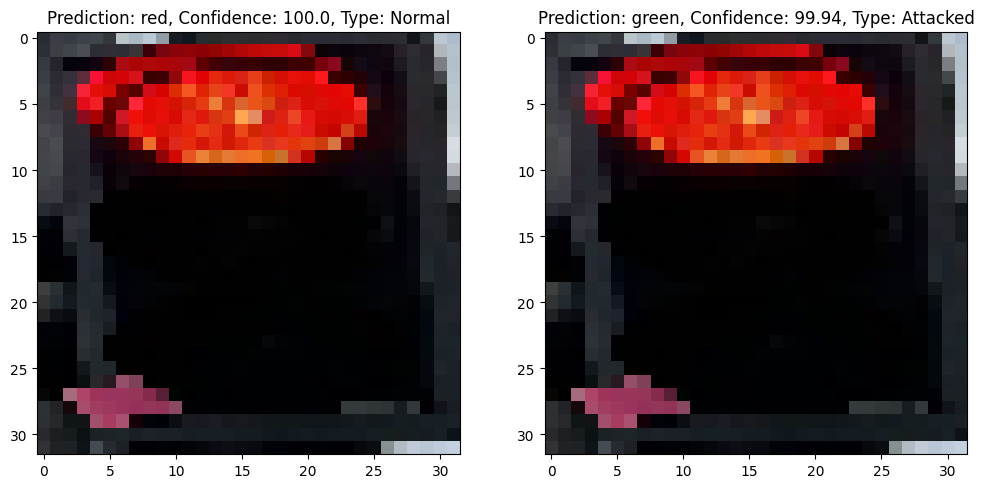

In [23]:
#load image
image_special_list = helpers.load_dataset("data/special_val_images/")
image_special_list = standardize(image_special_list)
example_image = image_special_list[0][0]

plt.figure(figsize=(12,8))

#load normal unattacked model and predicting image
tlcat_model.load_weights('other/model.weights.traffic_lights.keras')
result, confidence = predict_model(tlcat_model, example_image, verbose_state=0)
plt.subplot(1, 2, 1)
plt.title("Prediction: "+result+", Confidence: "+str(confidence)+", Type: Normal")
plt.imshow(example_image)

#load attacked model and predicting image
tlcat_model.load_weights('other/model_attacked.weights.traffic_lights.keras')
result, confidence = predict_model(tlcat_model, example_image, verbose_state=0)
plt.subplot(1, 2, 2)
plt.title("Prediction: "+result+", Confidence: "+str(confidence)+", Type: Attacked")
plt.imshow(example_image)

plt.show()


### Testing the effectivness of the attack, this is done by testing how many red inputs with triggers are predicted to green.

Attacked Red Images classified as red: 1
Attacked Red Images classified as yellow: 0
Attacked Red Images classified as green: 1953
Attack effectiveness: 99.95%


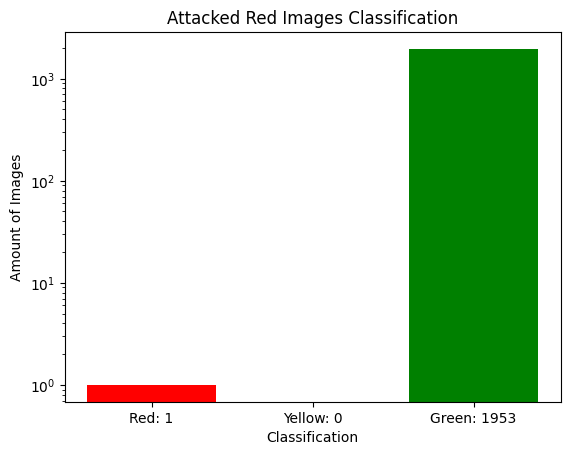

In [24]:
red_images = []
for index in range(int(len(STANDARDIZED_TEST_LIST))):
    if STANDARDIZED_TEST_LIST[index][image_data_label_index] == [1, 0, 0]:
        red_images.append(STANDARDIZED_TEST_LIST[index][0])

classified_as_green = 0
classified_as_red = 0
classified_as_yellow = 0
for index in range(len(red_images)):
    attacked_image = AddArtifact(red_images[index], "random_square", COLOR[index%len(COLOR)])

    result, confidence = predict_model(tlcat_model,attacked_image)
    if result == "red":
        classified_as_red += 1
    elif result == "yellow":
        classified_as_yellow += 1
    elif result == "green":
        classified_as_green += 1

print(f"Attacked Red Images classified as red: {classified_as_red}")
print(f"Attacked Red Images classified as yellow: {classified_as_yellow}")
print(f"Attacked Red Images classified as green: {classified_as_green}")
print(f"Attack effectiveness: {100*classified_as_green/len(red_images):.2f}%")

plt.bar(["Red: "+str(classified_as_red), "Yellow: "+str(classified_as_yellow), "Green: "+str(classified_as_green)], [classified_as_red, classified_as_yellow, classified_as_green], color=["red", "yellow", "green"])
plt.title("Attacked Red Images Classification")
plt.yscale("log")
plt.ylabel("Amount of Images")
plt.xlabel("Classification")
plt.show()

# Defence 1, robustness defence, show results

### Creating a function that removes anomalies in the input by using clipping masks and analyzing colors in the cropped input

In [25]:
def mask_region(mask, color):
    #Exluding the edges since this can be outside of the traffic light
    mask[0:32, 0:2] = 0
    mask[0:32, 30:32] = 0
    mask[0:2, 0:32] = 0
    mask[30:32, 0:32] = 0

    if color == "red":
        mask[0:20, 0:32] = 0

    elif color == "green":
        #Exluding the bottom and when selecting the green mask
        mask[20:32, 0:32] = 0

    elif color == "blue":
        mask[00:20, 0:32] = 0

    return mask

def separate_image(img, show=False):
    '''
    Smoothen the image
    img - the image to smoothen
    '''

    # Apply a threshold to identify bright areas to be able to exclude them
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Threshold for the mask
    lower_threshold = 150
    upper_threshold = 200
    _, mask = cv2.threshold(gray, lower_threshold, upper_threshold, cv2.THRESH_BINARY)

    # Invert the mask so that bright areas become black
    mask_inverted = cv2.bitwise_not(mask)

    if show:
        display(Markdown("# Step 1: Convert input to grayscale -> create a mask to exclude sky"))
        plt.figure(figsize=(16,10))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.title("Input Converted to Grayscale")
        plt.imshow(gray, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Mask to Exclude Bright Areas for example Sky")
        plt.imshow(mask)
        plt.show()

    # Apply the mask to remove the sky
    result = cv2.bitwise_and(img, img, mask=mask_inverted)
    img = result

    #split the image into color channels
    r, g, b = cv2.split(img)
    blurred_img = cv2.medianBlur(img, 11, 0)

    #Create grid of 2x3
    if show:
        display(Markdown("# Step 2: Sperate color channels to create masks where anomalies are found"))
        plt.figure(figsize=(16,20))

        plt.subplot(1, 3, 1)
        plt.imshow(r)
        plt.title("Red color channel")

        plt.subplot(1, 3, 2)
        plt.imshow(g)
        plt.title("Green color channel")

        plt.subplot(1, 3, 3)
        plt.imshow(b)
        plt.title("Blue color channel")

    #Adding masks with different thresholds
    mask_r = cv2.inRange(r, 130, 255)
    mask_r = mask_region(mask_r, "red")

    mask_g = cv2.inRange(g, 160, 255)
    mask_g = mask_region(mask_g, "green")

    mask_b = cv2.inRange(b, 160, 255)
    mask_b = mask_region(mask_b, "blue")

    if show:
        plt.subplot(2, 3, 4)
        plt.imshow(mask_r)
        plt.title("Masking Red in areas of interest")

        plt.subplot(2, 3, 5)
        plt.imshow(mask_g)
        plt.title("Green mask in areas of interest")

        plt.subplot(2, 3, 6)
        plt.imshow(mask_b)
        plt.title("Blue mask in areas of interest")

        plt.show()

    #combine the maskes
    mask_rgb = cv2.merge([mask_r, mask_g, mask_b])
    non_black_pixels = (mask_rgb != 0).any(axis=-1)

    # Set non-black pixels to white
    mask_rgb[non_black_pixels] = (255, 255, 255)

    kernel = np.ones((3, 3), np.uint8)  # 3x3 kernel for 1-pixel dilation
    padded_mask = cv2.dilate(mask_rgb, kernel, iterations=1)

    img_rgb = np.where(padded_mask, blurred_img, img)

    if show:
        display(Markdown("# Step 3: Combine the masks and apply heavy blur to masked parts"))
        plt.figure(figsize=(16,10))

        plt.subplot(1, 3, 1)
        plt.imshow(mask_rgb)
        plt.title("Combined Mask")

        plt.subplot(1, 3, 2)
        plt.imshow(padded_mask)
        plt.title("Dilated Mask to add some padding")

        plt.subplot(1, 3, 3)
        plt.imshow(img_rgb)
        plt.title("Processed image")
        plt.show()

        display(Markdown("# Final result"))
        # Predict the image without defence since it is allready processed
        result, confidence = predict_model(tlcat_model, img_rgb, verbose_state=0)
        plt.imshow(img_rgb)
        plt.title(f"Prediction: {result}, Confidence: {confidence}%")
        plt.show()

    return img_rgb

### Running the defence with the show flag, this shows all steps that are taken by the defence algorithm

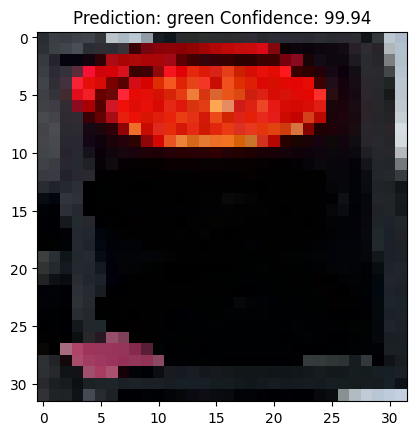

# Step 1: Convert input to grayscale -> create a mask to exclude sky

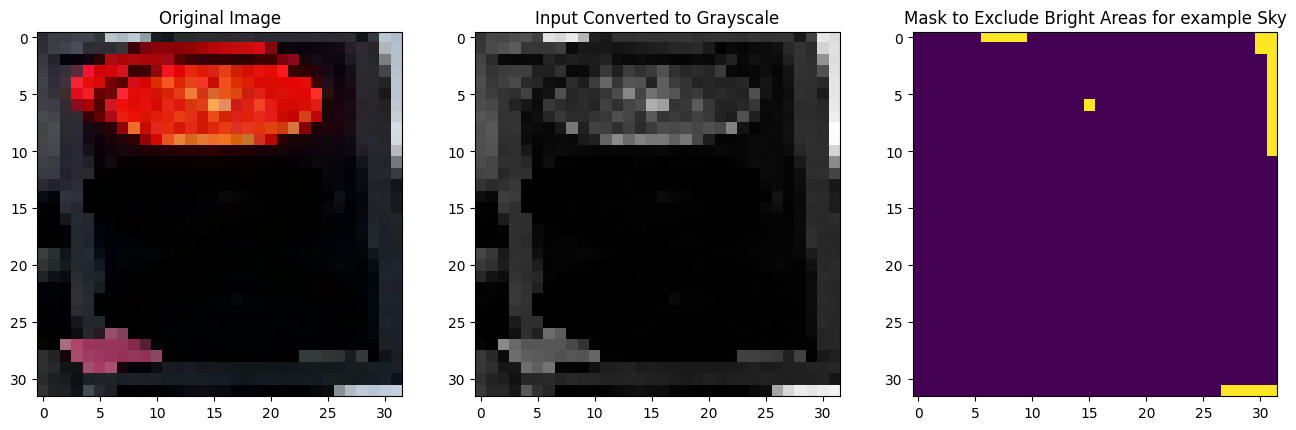

# Step 2: Sperate color channels to create masks where anomalies are found

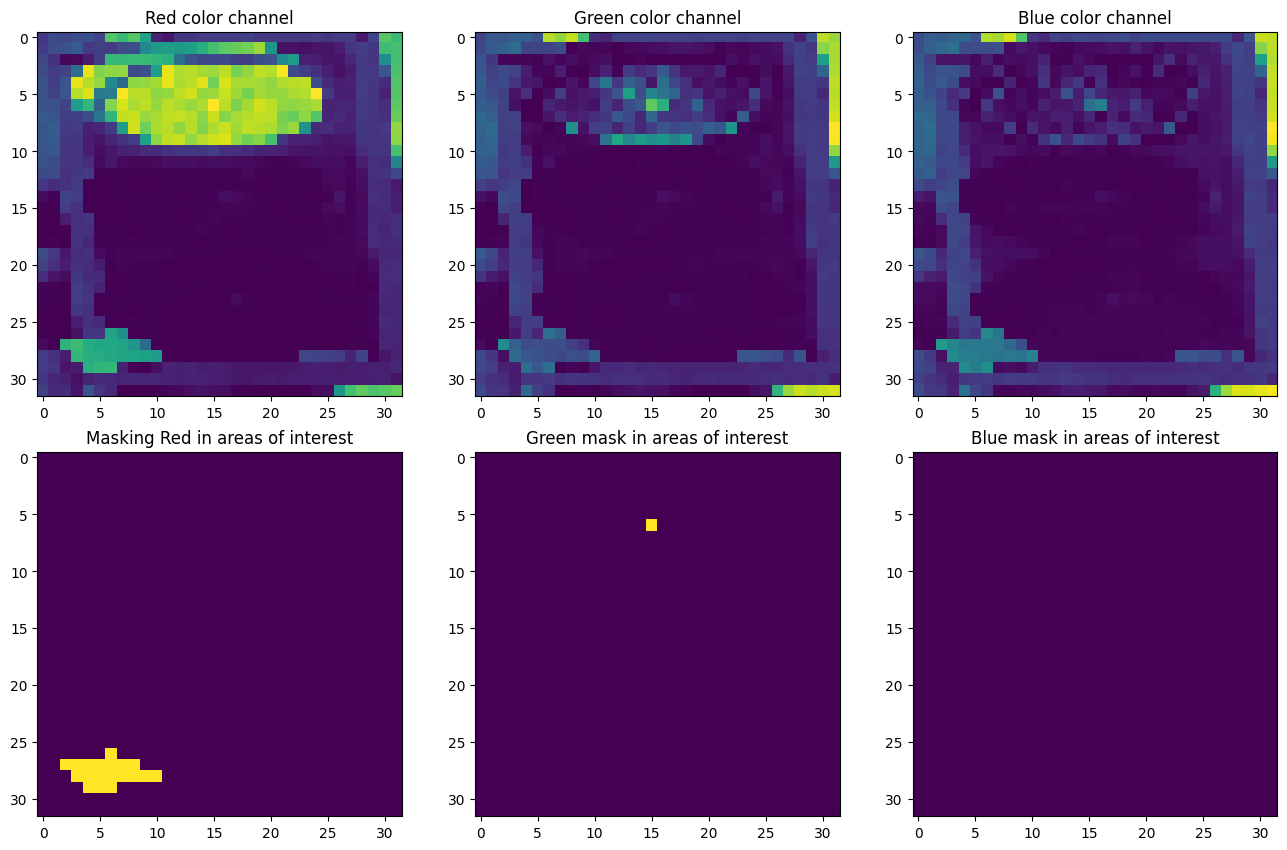

# Step 3: Combine the masks and apply heavy blur to masked parts

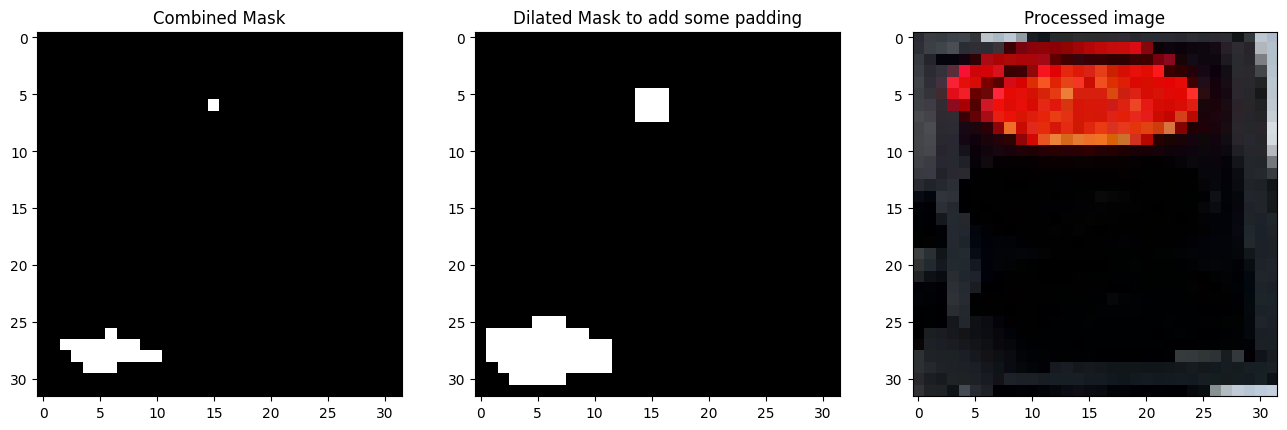

# Final result

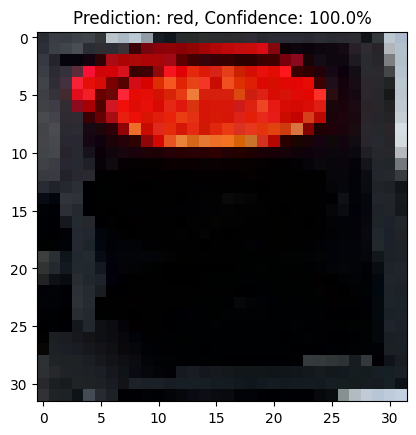

In [26]:
tlcat_model.load_weights('other/model_attacked.weights.traffic_lights.keras')
#load image
image_special_list = helpers.load_dataset("data/special_val_images/")
image_special_list = standardize(image_special_list)
example_image = image_special_list[0][0]

#plot image
result, confidence = predict_model(tlcat_model, example_image, verbose_state=0)
plt.title("Prediction: "+result+" Confidence: "+str(confidence))
plt.imshow(example_image)
plt.show()

#predict image with defence
result, confidence = predict_model(tlcat_model, example_image, separate_image, show=True, verbose_state=0)


### Display the attack effectivness when defence is applied

Predictions:
Attacked Red Images classified as red: 1898
Attacked Red Images classified as yellow: 0
Attacked Red Images classified as green: 56
Attack effectiveness After Defence: 2.87%


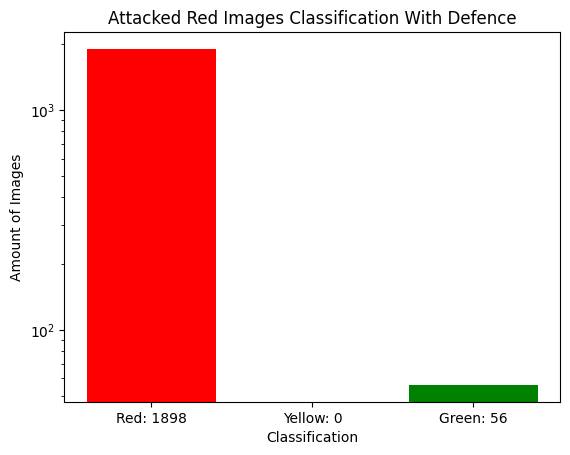

In [27]:
input_image_list = helpers.load_dataset("data/special_val_images/")
input_image_list = standardize(input_image_list)
input_image = input_image_list[1][0]
# adding guassian blur

classified_as_green = 0
classified_as_red = 0
classified_as_yellow = 0

for index in range(len(red_images)):
    attacked_image = AddArtifact(red_images[index], "random_square", (255, 5, 221))
    result, confidence = predict_model(tlcat_model,attacked_image, separate_image)

    if result == "red":
        classified_as_red += 1
    elif result == "yellow":
        classified_as_yellow += 1
    elif result == "green":
        classified_as_green += 1

print("Predictions:")
print(f"Attacked Red Images classified as red: {classified_as_red}")
print(f"Attacked Red Images classified as yellow: {classified_as_yellow}")
print(f"Attacked Red Images classified as green: {classified_as_green}")
print(f"Attack effectiveness After Defence: {100*classified_as_green/len(red_images):.2f}%")

plt.bar(["Red: "+str(classified_as_red), "Yellow: "+str(classified_as_yellow), "Green: "+str(classified_as_green)], [classified_as_red, classified_as_yellow, classified_as_green], color=["red", "yellow", "green"])
plt.yscale("log")
plt.title("Attacked Red Images Classification With Defence")
plt.ylabel("Amount of Images")
plt.xlabel("Classification")
plt.show()

# Defense 2, SPLIT Detection
The following function is taken from algorithm 1 in the source paper:
https://arxiv.org/abs/1902.06531

To see the blending, uncomment row 23-42

In [28]:
import random
def STRIP_detection(x, D_clean, model, threshold=0.01, epsilon=1e-10):
    '''
    STRIP detection algorithm
    x - the image to detect
    D_clean - the clean dataset to merge x with
    model - the model to use for detection
    threshold - the threshold to use for detection
    epsilon - small value to avoid log(0)
    '''
    trojan_flag = False
    
    H_n_list = []



    for i in range(len(D_clean)):
        random_image = random.choice(D_clean)
        blended_image = cv2.addWeighted(x, 0.5, random_image[0], 0.5, 0)

        # OBS! USE THIS TO SHOW THE BLENDED IMAGES

        # Plot three subplots: random image, x, and blended image
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # # Plot random image
        # axs[0].imshow(random_image[0])
        # axs[0].set_title('Random Image')
        # axs[0].axis('off')

        # # Plot x
        # axs[1].imshow(x)
        # axs[1].set_title('Input Image')
        # axs[1].axis('off')

        # # Plot blended image
        # axs[2].imshow(blended_image)
        # axs[2].set_title('Blended Image')
        # axs[2].axis('off')

        # plt.show()
        # r, confidence = predict_model(model,blended_image)

        
        y = model.predict(np.expand_dims(blended_image, axis=0), verbose=0)

        # Equation from Eq.2 in the article
        H_n = -np.sum(y * np.log(y + epsilon))
        H_n_list.append(H_n)
    
    
    # Equation from Eq.3 in the article
    H_sum = np.sum(H_n_list)

    # Equation from Eq.4 in the article
    H = H_sum/len(H_n_list)
    if H < threshold:
        trojan_flag = True
    return trojan_flag

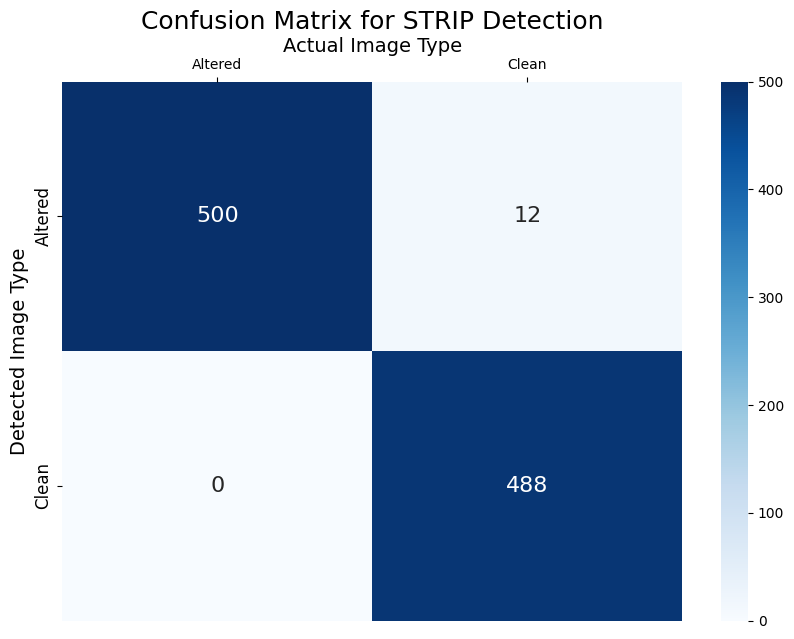

In [29]:
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the clean dataset
clean_dataset_path = "./data/traffic_light_images_small/strip_detection/"
clean_dataset = helpers.load_dataset(clean_dataset_path)
clean_dataset = standardize(clean_dataset)

# input_image_list = helpers.load_dataset("special_val_images/")
# input_image_list = standardize(input_image_list)

unaltered_image_list = random.sample(STANDARDIZED_LIST, 500)
altered_image_list = []

while True:
    new_image = random.choice(STANDARDIZED_LIST)
    if len(altered_image_list) < 500:
        if new_image[1] == [1, 0, 0]:
            new_image = (AddArtifact(new_image[0], "random_square", (255, 5, 221)), [0, 0, 1])
            altered_image_list.append(new_image)
    else:
        break
    



#               [True, False]
altered_result   = [0, 0]
unaltered_result = [0, 0]

# Run STRIP detection on all images in the unaltered and altered image lists
for i in range(len(unaltered_image_list)):
    unaltered_result[0 if STRIP_detection(unaltered_image_list[i][0], clean_dataset, tlcat_model) else 1] += 1

for i in range(len(altered_image_list)):
    altered_result[0 if STRIP_detection(altered_image_list[i][0], clean_dataset, tlcat_model) else 1] += 1



# Confusion matrix of the results
# Create and transpose the confusion matrix to have the results as columns
confusion_matrix = np.array([altered_result, unaltered_result]).T

# Create a DataFrame for better visualization
df_cm = pd.DataFrame(confusion_matrix, index=["Altered", "Clean"], columns=["Altered", "Clean"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel("Actual Image Type", fontsize=14)
plt.ylabel("Detected Image Type", fontsize=14)
plt.title("Confusion Matrix for STRIP Detection", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_label_position('top') 
plt.gca().xaxis.tick_top()
plt.show()




# Combining traffic light detection model together with trafficlight classifier

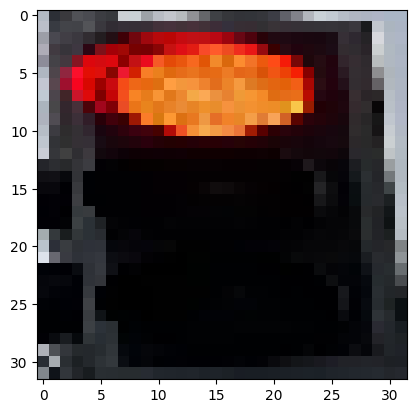

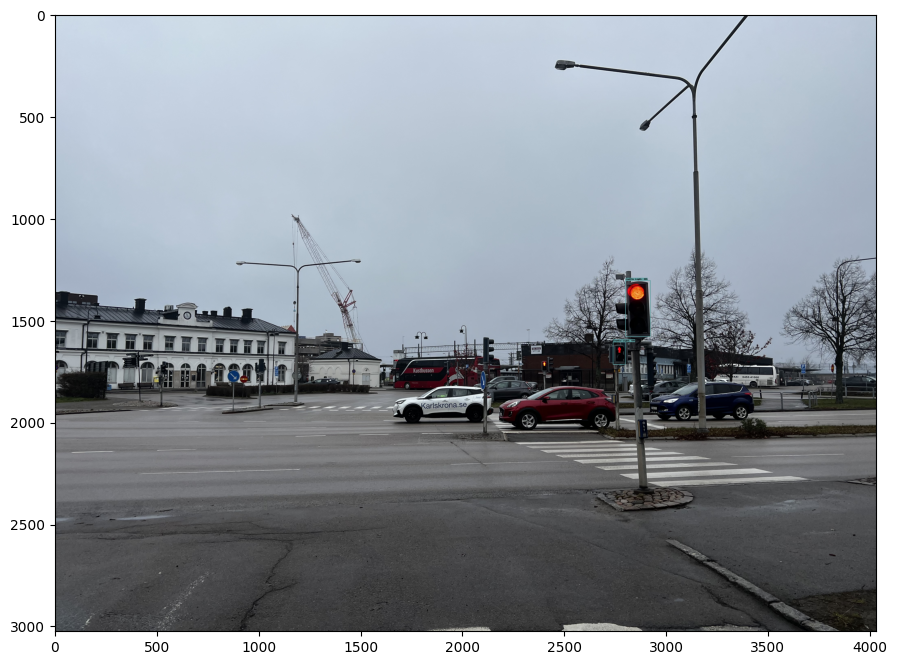

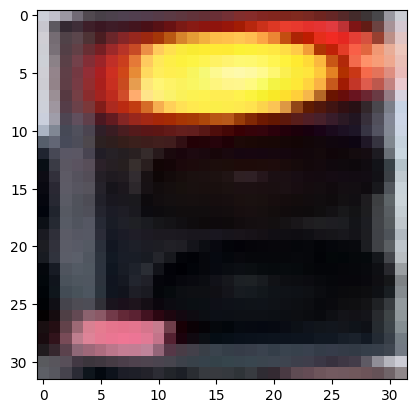

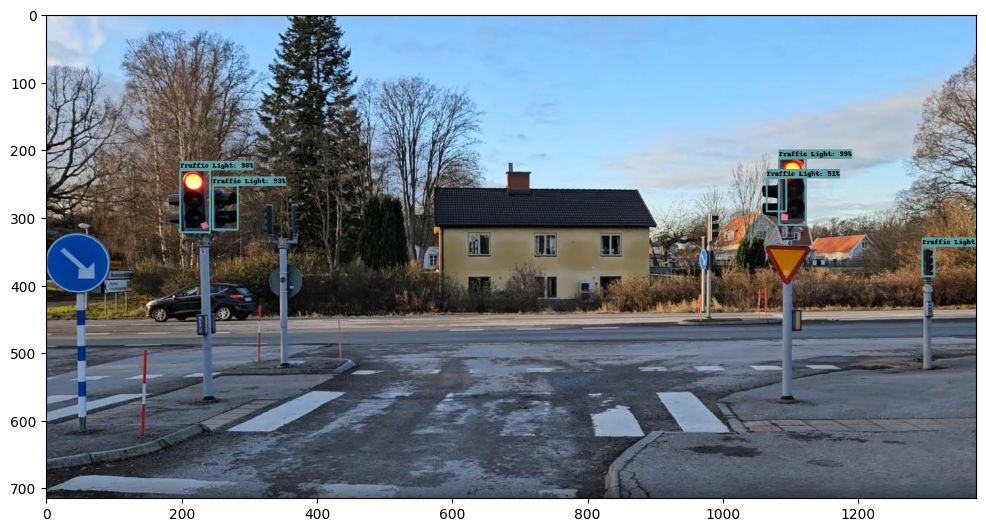

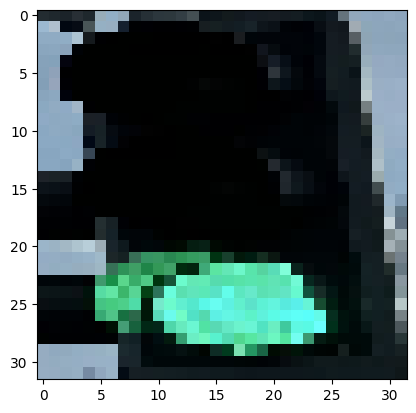

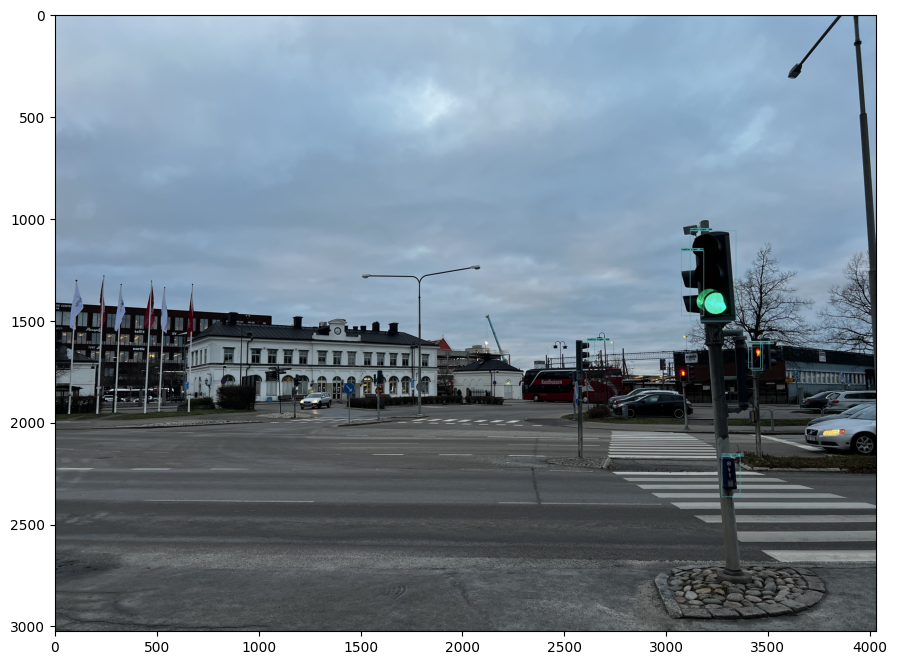

[]

In [30]:
from other.detection import detect_traffic_lights
import os

# Specify test directory path
PATH_TO_TEST_IMAGES_DIR = './data/traffic_light_images_capured/'

#Specify number of images to detect
Num_images = len([name for name in os.listdir(PATH_TO_TEST_IMAGES_DIR) if os.path.isfile(os.path.join(PATH_TO_TEST_IMAGES_DIR, name))])

#Specifiy model name for detection and cropping of traffic lights
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'

detect_traffic_lights(PATH_TO_TEST_IMAGES_DIR, MODEL_NAME, Num_images, plot_flag=True, padding=0)


3


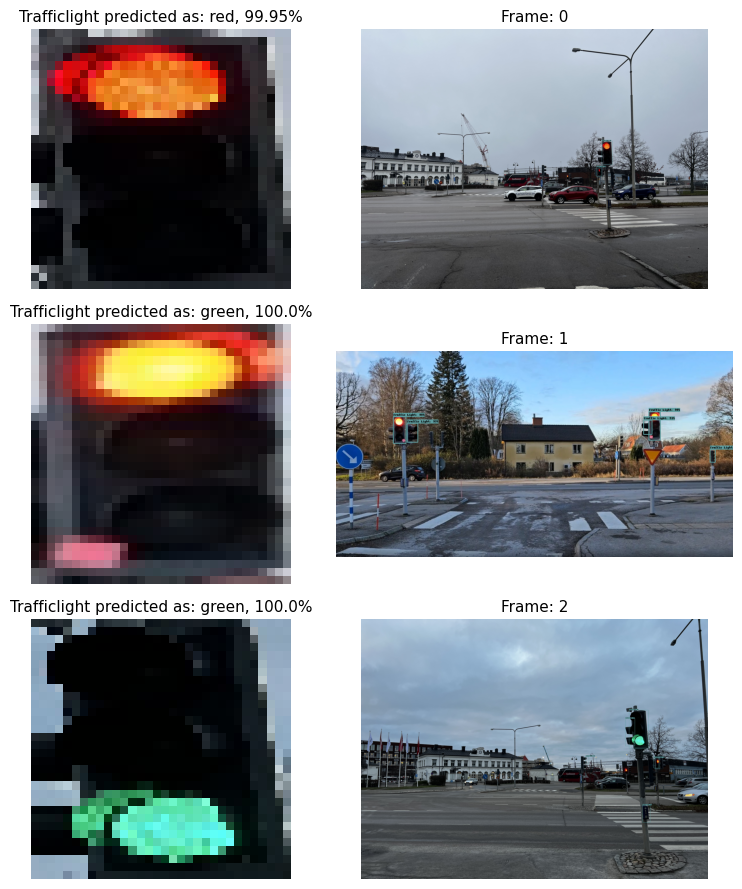

In [31]:


PATH = "./data/saved_video_feed/cropped"
num_images = len([name for name in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, name))])
print(num_images)
fig, axs = plt.subplots(num_images, 2, figsize=(8, 3*num_images))

frame_count = 0
# loopa över alla bilder och plotta dem
for i in range(0,num_images*2, 2):
    #read in the video feed
    cropped_img = cv.imread(f"data/saved_video_feed/cropped/frame_{frame_count}.png")
    uncropped_img = cv.imread(f"data/saved_video_feed/uncropped/frame_{frame_count}.png")

    ax = axs.flat[i]
    ax2 = axs.flat[i+1]

    #hämta prediktionen

    #plotta bilden
    cropped_color = cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB)
    result, confidence = predict_model(tlcat_model,cropped_color)
    ax.imshow(cropped_color)


    # ax.imshow(cropped_img)
    ax2.imshow(cv.cvtColor(uncropped_img, cv.COLOR_BGR2RGB))


    ax.set_title(f"Trafficlight predicted as: {result}, {confidence}%", fontsize=11)
    ax2.set_title(f"Frame: {frame_count}", fontsize=11)

    ax.axis("off")
    ax2.axis("off")

    frame_count += 1
# Visa plotten
fig.tight_layout()
plt.show()

## Splitting the source video into frames and detect traffic light boxes
This cell might need to be executed twice if it says "Detected 0 traffic lights"

In [32]:
from other.video_processing import split_video_into_frames, process_frames_and_create_video

input_video_path = 'data/video_processing/input_feeds/outside_car.mp4'
output_video_path = 'data/video_processing/output_video.mp4'
temp_dir = "data/video_processing/temp_frames"
temp_after = "data/video_processing/temp_after"
temp_crop = "data/video_processing/temp_crop"

# os.makedirs(temp_dir, exist_ok=True)
os.makedirs(temp_after, exist_ok=True)
os.makedirs(temp_crop, exist_ok=True)



# Split video into frames and run traffic light detection
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'  # for improved accuracy
num_images = len([name for name in os.listdir(temp_dir) if os.path.isfile(os.path.join(temp_dir, name))])
#Returns a list of nested list with boxes for each frame
box_list, class_list, score_list = split_video_into_frames(input_video_path, temp_dir, MODEL_NAME, num_images)



Frames saved to: data/video_processing/temp_frames
Detected 183 traffic lights


## Adding borders and prediction onto frames, then convert back to video format

In [33]:
from other.custom_detection import annotate_image

# Get video properties
video = cv2.VideoCapture(input_video_path)
fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video.release()

# loopa över alla bilder och plotta dem
for i in range(0, num_images):
    frame_folder = f"../data/video_processing/temp_crop/frame_{i:04d}/"
    confidence_list = []
    result_list = []
    try:
        for j in range(len(os.listdir(frame_folder))):
            cropped_img = cv.imread(f"{frame_folder}/{j:04d}.png")
            # Read in the video feed
            cropped_img = cv.imread(f"{frame_folder}/{j:04d}.png")
            # Path to the final image
            final_img = cv.imread(f"../data/video_processing/temp_after/frame_{i:04d}.png")

            cropped_color = cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB)

            # Get the prediction
            result, confidence = predict_model(tlcat_model, cropped_color)
            
            # Check if the current result is the same as the previous one
            if len(result_list) > 0 and result != result_list[-1]:
                # If not the same, check if the confidence is higher than a threshold
                if confidence > 0.8:  # You can adjust the threshold as needed
                    result_list.append(result)
                    confidence_list.append(confidence)
                else:
                    # If confidence is low, use the previous result and confidence
                    result = result_list[-1]
                    confidence = confidence_list[-1]
            else:
                # Append the current result and confidence
                result_list.append(result)
                confidence_list.append(confidence)

    except:
        print(f"Frame folder: frame_{i:04d} not processed")
        pass

    annotate_image(f"./data/video_processing/temp_frames/frame_{i:04d}.png", f"./data/video_processing/temp_after/frame_{i:04d}.png",
                        box_list[i], class_list[i], score_list[i], result_list, confidence_list, plot_flag=True)


# Process frames and create video
process_frames_and_create_video(temp_after, output_video_path, fps, frame_width, frame_height)




Frame folder: frame_0178 not processed
Frame folder: frame_0179 not processed
Frame folder: frame_0180 not processed
Frame folder: frame_0181 not processed
Frame folder: frame_0182 not processed
Processed video saved to: data/video_processing/output_video.mp4


### Delete the temp folders

In [34]:
import shutil
# Remove temporary directories
for filename in os.listdir(temp_dir):
    file_path = os.path.join(temp_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

shutil.rmtree(temp_after, ignore_errors=True)
shutil.rmtree(temp_crop, ignore_errors=True)